In [1]:
%load_ext autoreload
%autoreload 2

https://gitmemory.cn/repo/barbacbd/cluster

### TODO: 

* run baseline models with all features
* run baseline models ranking features and choosing best 5, 10, 20
* run GA with single metrics
* dev GA MOOP
* run GA with MOOP 

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns 
sns.set(style='ticks', palette='Set2')
sns.set_context("talk", font_scale=1.2)
import matplotlib.pyplot as plt
import random
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

from sklearn import svm 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.linear_model import Perceptron
import tensorflow as tf
import pickle 

import clust
import fs

In [2]:
madelon = pd.read_csv(Path("datasets/madelon.csv"))
madelon_t = madelon.pop("Class")

scene = pd.read_csv(Path("datasets/scene.csv"))
scene_t = scene.pop("Beach")

gisette = [pd.read_csv(Path("datasets/gisette_train.data"), header = None, sep = " ").drop(columns = [5000])]
gisette.append(pd.read_csv(Path("datasets/gisette_valid.data"), header = None, sep = " ").drop(columns = [5000]))
gisette = pd.concat(gisette, ignore_index = True)
gisette_t = [pd.read_csv(Path("datasets/gisette_train.labels"), header = None, sep = " ")]
gisette_t.append(pd.read_csv(Path("datasets/gisette_valid.labels"), header = None, sep = " "))
gisette_t = pd.concat(gisette_t, ignore_index = True)

gina = pd.read_csv(Path("datasets/gina_prior.csv"))
gina_t = gina.pop("label")

christensen = pd.read_csv(Path("datasets/christensen_inputs.csv"), header = None)
christensen_t = pd.read_csv(Path("datasets/christensen_outputs.csv"), header = None)
christensen_t[0] = np.where(christensen_t[0] == 3, 2, christensen_t[0])

datasets = {"madelon" : (madelon, madelon_t), 
            "scene" : (scene, scene_t), 
            "gisette" : (gisette, gisette_t), 
            "gina_prior" : (gina, gina_t), 
            "christensen" : (christensen, christensen_t)}

#### Describing Raw Datasets:

In [3]:
for ds_name, ds in datasets.items():
    print(f"{ds_name}: n {len(ds[0])}, m {len(ds[0].columns)}")

madelon: n 2600, m 500
scene: n 2407, m 299
gisette: n 7000, m 5000
gina_prior: n 3468, m 784
christensen: n 217, m 1413


In [10]:
gisette.columns = [f"f{i}" for i in range(len(gisette.columns))]
christensen.columns = [f"f{i}" for i in range(len(christensen.columns))]

#### Remove Features with unique values or a lot of missing 

In [20]:
for ds_name, ds in datasets.items():
    fs_obj = fs.FeatureSelector(ds[0], ds[1])

    fs_obj.identify_collinear(correlation_threshold = 0.95)
    cols_to_remove = fs_obj.ops['collinear']

    fs_obj.identify_missing(missing_threshold = 0.50)
    cols_to_remove.extend(fs_obj.ops['missing'])

    fs_obj.identify_single_unique()
    cols_to_remove.extend(fs_obj.ops['single_unique'])
    ds[0].drop(columns = cols_to_remove,  inplace = True)


10 features with a correlation magnitude greater than 0.95.

0 features with greater than 0.50 missing values.

0 features with a single unique value.

11 features with a correlation magnitude greater than 0.95.

0 features with greater than 0.50 missing values.

0 features with a single unique value.

111 features with a correlation magnitude greater than 0.95.

0 features with greater than 0.50 missing values.

29 features with a single unique value.

15 features with a correlation magnitude greater than 0.95.

0 features with greater than 0.50 missing values.

139 features with a single unique value.

40 features with a correlation magnitude greater than 0.95.

0 features with greater than 0.50 missing values.

0 features with a single unique value.



In [21]:
for ds_name, ds in datasets.items():
    print(f"{ds_name}: n {len(ds[0])}, m {len(ds[0].columns)}")
    ds[0].to_csv(Path(f"datasets/filtered/{ds_name}.csv"), index = False)
    ds[1].to_csv(Path(f"datasets/filtered/{ds_name}_target.csv"), index = False)

madelon: n 2600, m 490
scene: n 2407, m 288
gisette: n 7000, m 4860
gina_prior: n 3468, m 630
christensen: n 217, m 1373


#### Split FS dataset   


In [25]:
fs_datasets = {}
for ds_name, ds in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(ds[0], ds[1], test_size = 0.3, stratify = ds[1], random_state = 42)
    X_train.to_csv(Path(f"datasets/split/{ds_name}.csv"), index = False)
    X_test.to_csv(Path(f"datasets/split/{ds_name}_fs.csv"), index = False)
    y_train.to_csv(Path(f"datasets/split/{ds_name}_target.csv"), index = False)
    y_test.to_csv(Path(f"datasets/split/{ds_name}_target_fs.csv"), index = False)
    fs_datasets[ds_name] = (X_test, y_test)

#### Get Feature Ranking

In [5]:

feature_ranking = {}
for ds_name, ds in fs_datasets.items():
    fs_obj = fs.FeatureSelector(ds[0], ds[1])
    fs_obj.identify_zero_importance(task = 'classification', eval_metric='auc', n_iterations = 10, early_stopping = True)
    feature_ranking[ds_name] = fs_obj.feature_importances['feature'].values

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.84249	valid_0's binary_logloss: 0.530006
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.782583	valid_0's binary_logloss: 0.579746
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.828463	valid_0's binary_logloss: 0.54282
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.876388	valid_0's binary_logloss: 0.525484
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.829632	valid_0's binary_logloss: 0.546268
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.813121	valid_0's binary_logloss: 0.59467
Tra

In [6]:
with open('feature_rankings.pkl', 'wb') as f:
    pickle.dump(feature_ranking, f)

#### Read data 

In [215]:
datasets = {}
fs_datasets = {}
eval_datasets = {}

for ds_name in ["madelon", "scene", "gisette", "gina_prior", "christensen"]:
    datasets[ds_name] = (pd.read_csv(Path(f"datasets/filtered/{ds_name}.csv")), pd.read_csv(Path(f"datasets/filtered/{ds_name}_target.csv")))
    fs_datasets[ds_name] = (pd.read_csv(Path(f"datasets/split/{ds_name}_fs.csv")), pd.read_csv(Path(f"datasets/split/{ds_name}_target_fs.csv")))
    eval_datasets[ds_name] = (pd.read_csv(Path(f"datasets/split/{ds_name}.csv")), pd.read_csv(Path(f"datasets/split/{ds_name}_target.csv")))

In [7]:
with open('feature_rankings.pkl', 'rb') as f:
    feature_ranking = pickle.load(f)

In [197]:
imbalanced_datasets = ['scene']

#### Run Baseline Models

In [103]:
from util import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from skelm import ELMClassifier

In [35]:
models = {
    "LDA" : LinearDiscriminantAnalysis(),
    "SVM" : SVC(kernel = 'linear', C = 1),
    "ELM" : ELMClassifier(n_neurons = 20, random_state = 42),
    "Percepetron" : Perceptron(penalty = 'l2')
}

In [36]:
num_features = [1, 5, 10, 20, 50, 99999]
num_tests = 20
data = []
for ds_name, ds in eval_datasets.items():
    print(ds_name)
    scaler = StandardScaler()
    ds_scaled = pd.DataFrame(scaler.fit_transform(ds[0]), index = ds[0].index, columns = ds[0].columns)
    for model_name, model in models.items():
        print("\t", model_name)
        for nf in num_features:
            ds_selected_features = ds_scaled[feature_ranking[ds_name][:nf]]
            for t in range(num_tests):
                X_train, X_test, y_train, y_test = train_test_split(ds_selected_features, ds[1], test_size=0.2, random_state = t)
                if ds_name in imbalanced_datasets:
                    sm = SMOTE(random_state = t)
                    X_res, y_res = sm.fit_sample(X_train, y_train)
                else:
                    X_res = X_train
                    y_res = y_train

                start_time = time.time()
                model.fit(X_res.values, y_res.values)
                timespent = time.time() - start_time
                y_pred = model.predict(X_test.values)
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred) 

                model_data = {"model" : model_name, "dataset" : ds_name, "num_features" : nf, "accuracy" : acc, 'f1' : f1, "iteration" : t, 'timespent' : timespent}
                df = pd.DataFrame(model_data, index = [0])
                data.append(df)
    
    baseline_results = pd.concat(data, ignore_index = True)
    baseline_results.to_csv("baseline_resutls.csv", index = False)  

madelon
	 LDA
	 SVM
	 ELM
	 Percepetron
scene
	 LDA
	 SVM
	 ELM
	 Percepetron
gisette
	 LDA
	 SVM
	 ELM
	 Percepetron
gina_prior
	 LDA
	 SVM
	 ELM
	 Percepetron
christensen
	 LDA
	 SVM
	 ELM
	 Percepetron


In [37]:
baseline_results = pd.concat(data, ignore_index = True)
baseline_results.to_csv("baseline_resutls.csv", index = False)

In [98]:
baseline_results =  pd.read_csv("baseline_resutls.csv")


In [99]:
baseline_results[baseline_results['dataset'] == 'madelon'].groupby(['model', 'num_features']).mean().reset_index()

,model,num_features,accuracy,f1,iteration,timespent
0,ELM,1,0.535852,0.526503,9.5,0.004598
1,ELM,5,0.624725,0.629379,9.5,0.011898
2,ELM,10,0.599588,0.600954,9.5,0.007831
3,ELM,20,0.592308,0.588345,9.5,0.007526
4,ELM,50,0.535714,0.531617,9.5,0.009250
5,ELM,99999,0.535027,0.531218,9.5,0.025451
6,LDA,1,0.540385,0.538318,9.5,0.002609
7,LDA,5,0.612363,0.608565,9.5,0.003793
8,LDA,10,0.599451,0.596243,9.5,0.002948
9,LDA,20,0.586126,0.586889,9.5,0.004902


In [141]:
baseline_results.groupby(['dataset', 'model', 'num_features']).agg({'accuracy' : ['mean' ,np.std], 'f1' : ['mean', np.std], 'timespent' : np.sum}).to_csv("grouped.csv")

#### Reduzir Qtde de Variáveis

In [9]:
len(feature_ranking['gisette'])

4860

In [101]:
df = pd.read_csv(Path(f"./datasets/split/christensen_fs.csv"))
df.to_csv(Path(f"./datasets/split/christensen_fs_bkp.csv"), index = False)
df = df[feature_ranking['christensen'][:400]]
print(len(df.columns))
df.to_csv(Path(f"./datasets/split/christensen_fs.csv"), index = False)

400


#### Analisar Otimização GA

In [4]:
df = pd.read_csv(Path(f"./datasets/split/madelon_fs.csv"))

In [100]:
eval_datasets.keys()

dict_keys(['madelon', 'scene', 'gisette', 'gina_prior', 'christensen'])

In [142]:
import pickle
from deap import creator, base, tools, algorithms


In [143]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [180]:
folder = Path("./opt_log/")
folders = [x for x in folder.rglob("*") if x.is_dir()]
results = {}

for f in folders:
    dataset = pd.read_csv(f / "dataset.txt").columns.ravel()[0]

    if dataset not in results.keys():
        results[dataset] = {}
    
    metric = pd.read_csv(f / "model_config").columns[1].replace("[", "").replace("]", "").replace("'", "") 

    results[dataset][metric] = {}

    with open(f / "checkpoint.pkl", "rb") as file:
        data = pickle.load(file)

    results[dataset][metric]['halloffame'] = data['halloffame'].items
    results[dataset][metric]['logbook'] = data['logbook']
    
    if (f / "result.csv").exists():
        best = pd.read_csv(f / "result.csv")
        results[dataset][metric]['best'] = best

In [198]:
models = {
    "LDA" : LinearDiscriminantAnalysis(),
    "SVM" : SVC(kernel = 'linear', C = 1),
    "ELM" : ELMClassifier(n_neurons = 20, random_state = 42)
}



In [233]:
num_tests = 5
data = []
executed = {}
for ds_name, r in results.items():
    print(ds_name)
    if ds_name not in executed.keys():
        executed[ds_name] = {}

    ds = eval_datasets[ds_name]
    scaler = StandardScaler()
    ds_scaled = pd.DataFrame(scaler.fit_transform(ds[0]), index = ds[0].index, columns = ds[0].columns)
    for metric, opt_data in r.items():  
        print(metric)
        if metric not in executed[ds_name].keys():
            executed[ds_name][metric] = []
        for ind in opt_data['halloffame']:
            ind_hash = ','.join([str(x) for x in ind])
            if ind_hash in executed[ds_name][metric]: 
                continue
            else:
                executed[ds_name][metric].append(ind_hash)

            df = pd.DataFrame([ind], columns = fs_datasets[ds_name][0].columns, index = [0])
            selected_features = np.sort(df.loc[:, ~df.isin([0]).any(axis=0)].columns)
            if 'Unnamed: 0' in selected_features:
                selected_features = [x for x in selected_features if x != 'Unnamed: 0']

            ds_selected_features = ds_scaled[selected_features]
            for model_name, model in models.items():
                print("\t", model_name)
                for t in range(num_tests):
                    X_train, X_test, y_train, y_test = train_test_split(ds_selected_features, ds[1], test_size=0.2, random_state = t)
                    if ds_name in imbalanced_datasets:
                        sm = SMOTE(random_state = t)
                        X_res, y_res = sm.fit_sample(X_train, y_train)
                    else:
                        X_res = X_train
                        y_res = y_train

                    start_time = time.time()
                    model.fit(X_res.values, y_res.values)
                    timespent = time.time() - start_time
                    y_pred = model.predict(X_test.values)
                    acc = accuracy_score(y_test, y_pred)
                    f1 = f1_score(y_test, y_pred) 

                    model_data = {"model" : model_name, 
                                    "dataset" : ds_name, 
                                    "num_features" : len(ds_selected_features.columns), 
                                    "metric" : metric, 
                                    "accuracy" : acc, 
                                    'f1' : f1, 
                                    'timespent' : timespent,
                                    "Silhouette" : silhouette_score(fs_datasets[ds_name][0][selected_features], fs_datasets[ds_name][1]),
                                    "Calinski-Harabasz" : calinski_harabasz_score(fs_datasets[ds_name][0][selected_features], fs_datasets[ds_name][1]),
                                    "Davies_Bouldin" : davies_bouldin_score(fs_datasets[ds_name][0][selected_features], fs_datasets[ds_name][1])}
                    df = pd.DataFrame(model_data, index = [0])
                    data.append(df)
    
    final_results = pd.concat(data, ignore_index = True)
    final_results.to_csv("final_results.csv", index = False)  

final_results = pd.concat(data, ignore_index = True)
final_results.to_csv("final_results.csv", index = False)  

madelon
Calinski-Harabasz
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
Davies-Bouldin
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
Silhouette
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
Dunn
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
scene
Calinski-Harabasz
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
	 LDA
	 SVM
	 ELM
Davies-Bouldin
	 LD

In [235]:
final_results.groupby(['dataset', 'model', 'metric', 'num_features']).agg({'accuracy' : ['mean' ,np.std], 'f1' : ['mean', np.std], 'timespent' : np.sum}).to_csv("grouped_final.csv")

In [292]:
gen_db = [x['gen'] for x in results['gisette']['Davies-Bouldin']['logbook']]
avg_db = [x['avg'] for x in results['gisette']['Davies-Bouldin']['logbook']]
max_db = [x['max'] for x in results['gisette']['Davies-Bouldin']['logbook']]
std_db = [x['std'] for x in results['gisette']['Davies-Bouldin']['logbook']]

gen_sil = [x['gen'] for x in results['gisette']['Silhouette']['logbook']]
avg_sil= [x['avg'] for x in results['gisette']['Silhouette']['logbook']]
max_sil = [x['max'] for x in results['gisette']['Silhouette']['logbook']]
std_sil = [x['std'] for x in results['gisette']['Silhouette']['logbook']]


gen_ch = [x['gen'] for x in results['gisette']['Calinski-Harabasz']['logbook']]
avg_ch = [x['avg'] for x in results['gisette']['Calinski-Harabasz']['logbook']]
max_ch = [x['max'] for x in results['gisette']['Calinski-Harabasz']['logbook']]
std_ch = [x['std'] for x in results['gisette']['Calinski-Harabasz']['logbook']]


# max_value = np.max(max_db)
# avg_db /= max_value
# max_db /= max_value
# std_db /= max_value

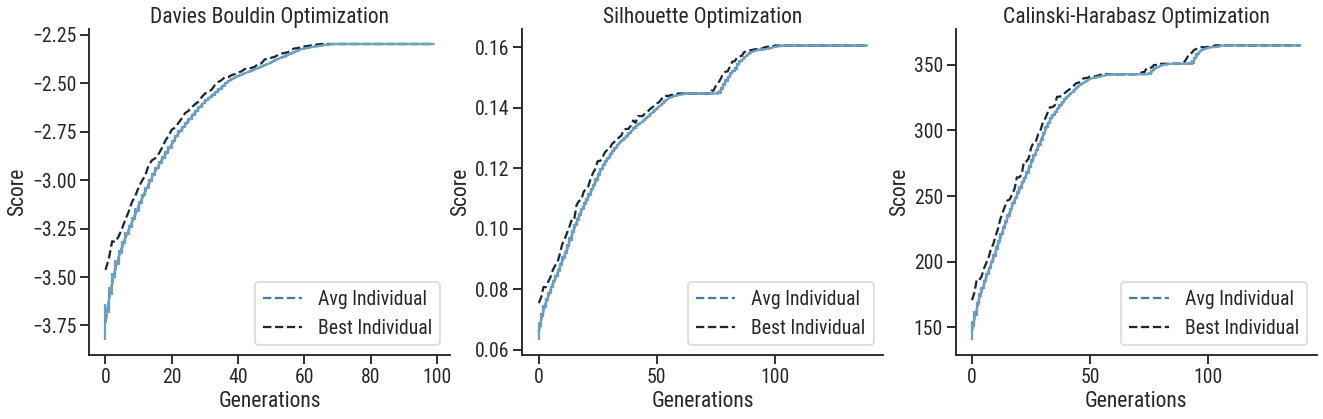

In [296]:
fig, ax = plt.subplots(figsize = (22, 6), nrows=1, ncols=3)
colors = ['#162936', '#2c526d', '#437ba3',  '#6ea0c4', '#a4c4da' ,'#c9dbe9']
ax[0].plot(gen_db, avg_db, '--', color = '#437ba3', label = 'Avg Individual')
ax[0].errorbar(gen_db, avg_db, yerr = std_db, color = '#6ea0c4')
ax[0].plot(gen_db, max_db, '--', color = '#162936', label = 'Best Individual')
ax[0].legend()
ax[0].set_title("Davies Bouldin Optimization")
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Generations")

ax[1].plot(gen_sil, avg_sil, '--', color = '#437ba3', label = 'Avg Individual')
ax[1].errorbar(gen_sil, avg_sil, yerr = std_sil, color = '#6ea0c4')
ax[1].plot(gen_sil, max_sil, '--', color = '#162936', label = 'Best Individual')
ax[1].legend()
ax[1].set_title("Silhouette Optimization")
ax[1].set_ylabel("Score")
ax[1].set_xlabel("Generations")


ax[2].plot(gen_ch, avg_ch, '--', color = '#437ba3', label = 'Avg Individual')
ax[2].errorbar(gen_ch, avg_ch, yerr = std_ch, color = '#6ea0c4')
ax[2].plot(gen_ch, max_ch, '--', color = '#162936', label = 'Best Individual')
ax[2].legend()
ax[2].set_title("Calinski-Harabasz Optimization")
ax[2].set_ylabel("Score")
ax[2].set_xlabel("Generations")

sns.despine()
plt.savefig("optimization.pdf", bbox_inches = "tight")


In [245]:
final_results

,model,dataset,num_features,metric,accuracy,f1,timespent,Silhouette,Calinski-Harabasz,Davies_Bouldin,teste
0,LDA,madelon,80,Calinski-Harabasz,0.554945,0.554945,0.020439,0.024663,22.559776,5.625113,0
1,LDA,madelon,80,Calinski-Harabasz,0.618132,0.621253,0.016004,0.024663,22.559776,5.625113,1
2,LDA,madelon,80,Calinski-Harabasz,0.563187,0.539130,0.010998,0.024663,22.559776,5.625113,2
3,LDA,madelon,80,Calinski-Harabasz,0.552198,0.560647,0.026610,0.024663,22.559776,5.625113,3
4,LDA,madelon,80,Calinski-Harabasz,0.560440,0.558011,0.016994,0.024663,22.559776,5.625113,4
...,...,...,...,...,...,...,...,...,...,...,...
2545,ELM,christensen,96,Silhouette,0.935484,0.941176,0.000000,0.383809,37.509888,1.176157,2545
2546,ELM,christensen,96,Silhouette,0.903226,0.896552,0.000000,0.383809,37.509888,1.176157,2546
2547,ELM,christensen,96,Silhouette,0.903226,0.909091,0.000000,0.383809,37.509888,1.176157,2547
2548,ELM,christensen,96,Silhouette,0.967742,0.967742,0.000000,0.383809,37.509888,1.176157,2548


In [230]:
final_results.head()

,model,dataset,num_features,metric,accuracy,f1,timespent,Silhouette,Calinski-Harabasz,Davies_Bouldin
0,LDA,gisette,4900,Calinski-Harabasz,0.954082,0.952681,0.071998,0.151461,364.679005,2.308747
1,LDA,gisette,4900,Calinski-Harabasz,0.946939,0.946830,0.115001,0.151461,364.679005,2.308747
2,LDA,gisette,4900,Calinski-Harabasz,0.955102,0.956522,0.095999,0.151461,364.679005,2.308747
3,LDA,gisette,4900,Calinski-Harabasz,0.940816,0.943359,0.084001,0.151461,364.679005,2.308747
4,LDA,gisette,4900,Calinski-Harabasz,0.942857,0.944664,0.097999,0.151461,364.679005,2.308747


#### Plots

In [34]:
import seaborn as sns 
sns.set(style='ticks', palette='Set2')
sns.set_context("talk", font_scale=1.2)
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm


In [136]:
font_path = "C:\\Users\\AniltonCardoso\\OneDrive - BITKA\\Projetos\\CustomFonts"
from matplotlib import font_manager
font_dirs = [font_path]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [137]:
csfont = {'fontname':'Roboto Condensed'}
hfont = {'fontname':'Roboto Condensed'}
matplotlib.rc('font',family='Roboto Condensed')
plt.rcParams.update({
    "text.usetex": False})

In [25]:
def default_plot_layout(ax, title, xlabel, ylabel):
    ax.set_title(title, size = 16)
    ax.set_ylabel(ylabel, size = 14)
    ax.set_xlabel(xlabel, size = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    
def fill_percentage(ax, total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total * 100),
                ha="center", fontsize = 12) 

In [115]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [77]:
best5 = feature_ranking['madelon'][:5]
best10 = feature_ranking['madelon'][:10]
random_5 = feature_ranking['madelon'][np.random.randint(1, len(feature_ranking['madelon']), size = 5)]

In [116]:
exp = {}

silhouette = []
ch = []
db = []
accs = []
scaler = StandardScaler()
ds_scaled = pd.DataFrame(scaler.fit_transform(eval_datasets['madelon'][0]), index =  eval_datasets['madelon'][0].index, columns =  eval_datasets['madelon'][0].columns)

for i in range(1000):
    size = np.random.randint(5, 20)
    features = np.random.choice(feature_ranking['madelon'], size = size)
    features = np.sort(features)
    silhouette.append(silhouette_score(fs_datasets['madelon'][0][features], fs_datasets['madelon'][1]))
    ch.append(calinski_harabasz_score(fs_datasets['madelon'][0][features], fs_datasets['madelon'][1]))
    db.append(davies_bouldin_score(fs_datasets['madelon'][0][features], fs_datasets['madelon'][1]))
    model = LinearDiscriminantAnalysis()
    X_train, X_test, y_train, y_test = train_test_split(ds_scaled[features], eval_datasets['madelon'][1], test_size = 0.2, random_state = 42)
    model.fit(X_train, y_train)
    accs.append(accuracy_score(y_test, model.predict(X_test)))


In [117]:
from scipy.stats import linregress
#slope, intercept, r_value, p_value, std_err

s_reg = linregress(silhouette, accs)
c_reg = linregress(ch, accs)
d_reg = linregress(db, accs)



In [120]:
d_reg

LinregressResult(slope=-0.0010103242789462404, intercept=0.5232161064159675, rvalue=-0.37737310877583063, pvalue=3.3835708267908626e-35, stderr=7.848095989329727e-05)

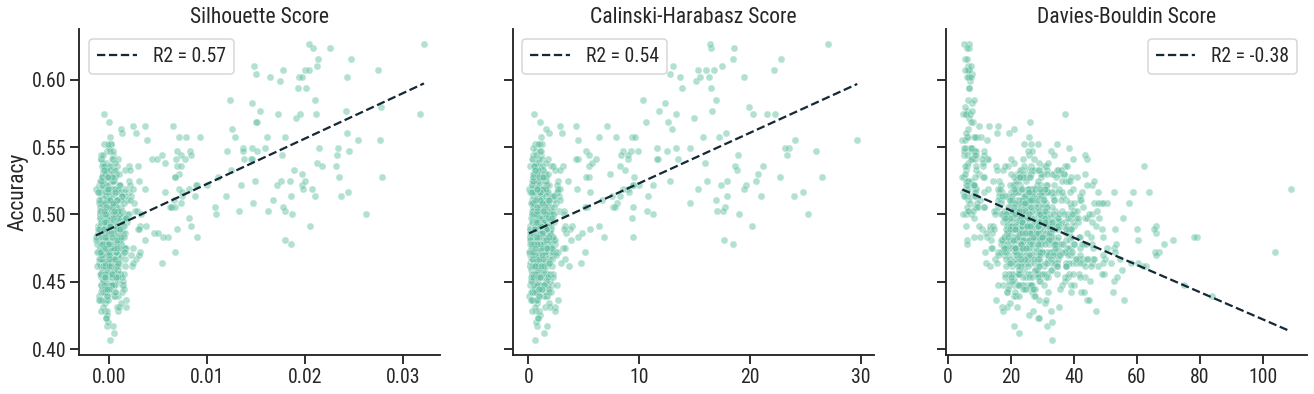

In [140]:
fig, ax = plt.subplots(figsize = (22, 6), nrows=1, ncols=3, sharey = True)

sns.scatterplot(x = silhouette, y = accs, ax = ax[0], s = 50, alpha = 0.5)
sil_data = np.linspace(np.min(silhouette), np.max(silhouette), 20)
ax[0].plot(sil_data, s_reg.intercept + sil_data * s_reg.slope, '--', color = '#162936', label = "R2 = " + str(np.round(s_reg.rvalue, 2)))
ax[0].legend()
ax[0].set_title("Silhouette Score")
ax[0].set_ylabel("Accuracy")
sns.scatterplot(x = ch, y = accs, ax = ax[1], s = 50, alpha = 0.5)
sil_data = np.linspace(np.min(ch), np.max(ch), 20)
ax[1].plot(sil_data, c_reg.intercept + sil_data * c_reg.slope, '--', color = '#162936', label = "R2 = " + str(np.round(c_reg.rvalue, 2)))
ax[1].legend()
ax[1].set_title("Calinski-Harabasz Score")
sns.scatterplot(x = db, y = accs, ax = ax[2], s = 50, alpha = 0.5)
sil_data = np.linspace(np.min(db), np.max(db), 20)
ax[2].plot(sil_data, d_reg.intercept + sil_data * d_reg.slope, '--', color = '#162936', label = "R2 = " + str(np.round(d_reg.rvalue, 2)))
ax[2].legend()
ax[2].set_title("Davies-Bouldin Score")
sns.despine()
plt.savefig("random.pdf", bbox_inches = "tight")


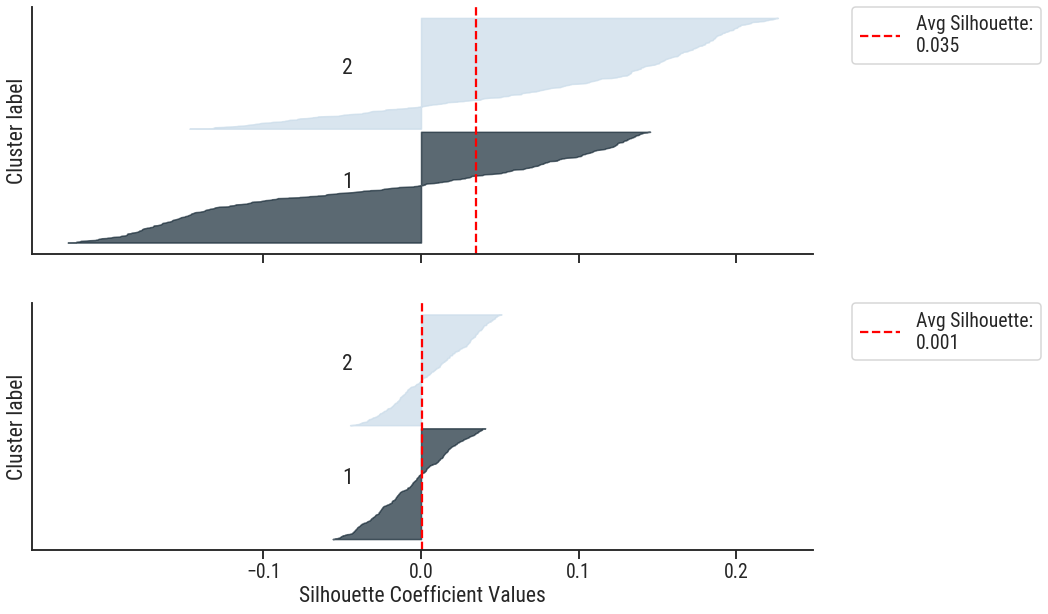

In [76]:
silhouette_avg_best = silhouette_score(fs_datasets['madelon'][0][best5], fs_datasets['madelon'][1])
silhouette_avg_rnd = silhouette_score(fs_datasets['madelon'][0][random_5], fs_datasets['madelon'][1])

cluster_labels = np.squeeze(fs_datasets['madelon'][1].values)

sample_silhouette_values_rnd = silhouette_samples(fs_datasets['madelon'][0][random_5], cluster_labels)
sample_silhouette_values_best = silhouette_samples(fs_datasets['madelon'][0][best5], cluster_labels)

n_clusters = len(np.unique(cluster_labels))
y_lower = 10

fig, ax = plt.subplots(figsize = (14, 10), nrows=2, ncols=1, sharex = True)
colors = ['#162936', '#c9dbe9']
index= 0 

for i in np.unique(cluster_labels):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values_best[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = colors[index]
    ax[0].fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values_rnd[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = colors[index]
    ax[1].fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax[1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    index +=1


ax[1].set_xlabel("Silhouette Coefficient Values")
ax[0].set_ylabel("Cluster label")
ax[1].set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax[0].axvline(x=silhouette_avg_best, color="red", linestyle="--", label = "Avg Silhouette:\n" + str(np.round(silhouette_avg_best, 3)))
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].axvline(x=silhouette_avg_rnd, color="red", linestyle="--", label = "Avg Silhouette:\n" + str(np.round(silhouette_avg_rnd, 3)))
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[0].set_yticks([])  # Clear the yaxis labels / ticks
ax[1].set_yticks([])  # Clear the yaxis labels / ticks
ax[0].set_xticks([-0.1, 0, 0.1, 0.2])
sns.despine()
plt.savefig("silhouette_example.pdf", bbox_inches = "tight")
